<a href="https://colab.research.google.com/github/gcorani/bda/blob/main/nbooks/3_Bayesian_hypthotesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)


# Bayesian Hypothesis Testing for comparing two groups

Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``

# Reference for Bayesian t-test


> Kruschke J, **Doing Bayesian Data Analysis**, Ch. 12

# Shortcoming of frequentist tests
* They cannot represent domain knowledge, as they only consider information from the sample.
  
* Then they fail-to-reject the null hypothesis they only make a *weak* decision.

> Failing to reject $H_0$ implies that we have not found sufficient evidence to reject H0, that is, to make a strong statement. Failing to reject H0 does not necessarily mean that there is a high probability that H0 is true. It may simply mean that more data are required to reach a strong conclusion.


# If we could make a strong decisione in favor  the null hypothesis verifying it..

* We could for instance:

  * discover that two classifiers have practically the same accuracy and thus  choose the one which is easier to deploy
  
  * discover that two drugs are pratically equivalent effective and focus our analysis on other issues (costs, side-effects, etc)

# Region of practical equivalence (rope)
      
* To make a strong decision in favor of the null hypothesis we need defining
a region of practical equivalence (rope) on the variable about which we make inference.

* If we are comparing the accuracy of classifiers, we can consider them practically equivalent if their difference of accuracy is for instance within   $\pm 0.01$ (assuming accuracy to range in 0,1).

* We then check the posterior probability of the difference of accuracy lying wihtin the rope.

# Bayesian tests

* Allow representing domain knowledge in the prior (it is recommended to perform some prior sensitivity analysis).

* They compute the posterior probability of the null and of the alternative hypothesis.

* If the posterior probability of $H_0$ is large, we actually accept $H_0$.
  
* We can define $H_0$ and $H_1$ so that the hypothesis have a practical meaning; this is done by defining a region of practical equivalence (ROPE). In turn, this is a parameter which is chosen subjectively and which reflects the knowledge of the analyst.


# Drug trial evaluation

* We  want to  evaluate  of a drug that is supposed to increase intelligence.

* We have IQ measures  of:
    * 47 individuals receiving the drug  (treatment group)
    * 42 individuals  receiving the placebo (control group).
    
* Some observations are however far from the mean.

In [ ]:
iq_drug = np.array ([101,100,102,104,105,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,104,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,103,103,100,101,103,104,100,101])
iq_placebo = np.array ([ 99,101,100,101,99,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,98,99])



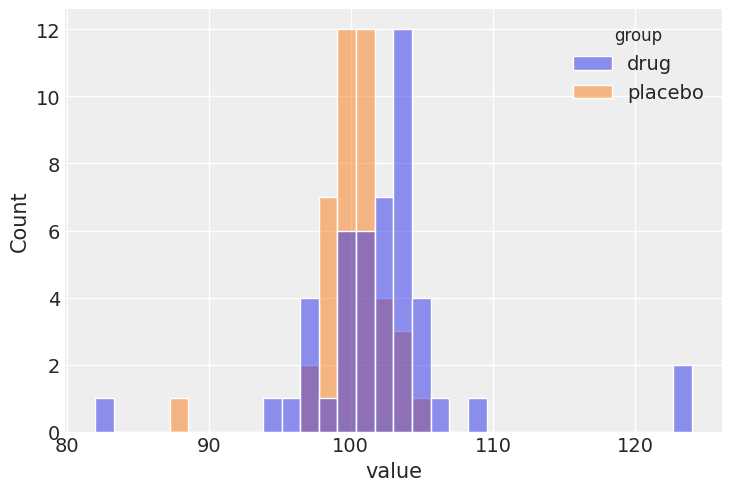

In [ ]:
y  = pd.DataFrame(dict(value=np.r_[iq_drug, iq_placebo], group=np.r_[['drug']*len(iq_drug), ['placebo']*len(iq_placebo)]))
sns.histplot(data=y, x="value", hue="group");

# Setup

* We have two samples, from which we can compute:

    * observed means, also known as sample means: ($\bar{x}_1$, $\bar{x}_2$)

    * sample standard deviations ($s_1, s_2$)

    * numerosity ($n_1, n_2$)


* The sample are drawn from two populations with unknown parameters $\mu_1, \mu_2, \sigma_1, \sigma_2$.

* The sample mean of the drug group  is superior, but:

    * there is a lot of variability within groups
    * there are some outliers.

# Possible research questions

* We will make inference (compute the posterior density of) about the difference between the mean of the two populations, $\mu_1 - \mu_2$



## Are the two means significantly different?
  * frequentist answer: two-tailed test
  * Bayesian answer: check whether the HDI of $\mu_1 - \mu_2$ includes  0.
     
     
## Does the drug have a *statistically* positive effect?
  * frequentist answer: one-tailed  test
  * Bayesian answer: posterior probability $P(\mu_1 - \mu_2 >0)$


## Which is the probability of drug of being *practically*  effective / non effective?
  * Bayesian answer:  define a rope and compute the posterior probability of $\mu_1 - \mu_2$ being inside or outside the rope.



# Frequentist test (t-test for two samples)
We want to demonstrate that the drug is effective:


\begin{align*}
H_0: \; & \mu_{\text{drug}} \leq \mu_{\text{placebo}} \\
H_1: \; & \mu_{\text{drug}} > \mu_{\text{placebo}}
\end{align*}

Outcome:
* $t$ statistic:  1.92
* critical value:  1.66
* We do not reject the null hypothesis. No strong evidence of the effectiveness of the drug.


In [ ]:
import scipy.stats as stats

x_bar_drug    = np.mean(iq_drug)
x_bar_placebo = np.mean(iq_placebo)
var_drug      = np.var(iq_drug)
var_placebo   = np.var(iq_placebo)

n_drug    = len(iq_drug)
n_placebo = len(iq_placebo)

weighted_sum_var = ( (n_drug - 1) * var_drug + (n_placebo -1 ) * var_placebo)
var_pooled =  weighted_sum_var / ( n_drug - 1 + n_placebo -1)
std_err =  np.sqrt( var_pooled * (1/n_drug + 1/n_placebo))

# statistic
t = (x_bar_drug - x_bar_placebo) / std_err

print("t statistic: ", np.round(t,2))

#t distribution with (n_drug + n_placebo - 2 ) degrees of freedom
critical = stats.t.ppf(0.95, df= n_drug + n_placebo - 2)
print("critical value: ", np.round(critical,2))
#the test does not reject the null.
#We cannot rule out that the drug is as effective as the placebo.

t statistic:  1.92
critical value:  1.66


# Main idea

* We will fit a normal-normal model on each group.


* Then we will study the posterior distribution of the difference ($\mu_1 - \mu_2$)


* Recall the normal-normal model:
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu}) \\
\sigma &  \sim \text{half-normal}(\xi) \\
y & \sim N(\mu, \sigma) \\
\end{align*}


# Background information to set the prior

* The IQ can be interpreted according to the <a href="https://www.123test.com/interpretation-of-an-iq-score/"> IQ scale meaning </a>.

    * its  mean in the population is  about 100
    * the mean IQ is believed to be in (80, 120).
    * extreme values of IQ  are 60 ( cognitively impaired) and 140 (gifted). A plausible value of standard deviation in the population is thus   (100 - 60)/2 = 20.



# Prior for $\mu_{\text{drug}}$ and $\mu_{\text{placebo}}$

* The  mean IQ of the population  lies in (80, 120);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{drug}}   \sim  N (100, 10 )
$$
$$
\mu_{\text{placebo}}   \sim  N (100, 10 )
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.



In [ ]:
#Here we tune the half-normal prior for sigma, adjusting the scale to have the median close to 20.
from scipy.stats import halfnorm
# this yields a  diffuse prior, but still defined over plausible range.
pd.DataFrame(halfnorm.rvs(scale=30, size=10000)).describe()

,0
count,10000.000000
mean,24.089939
std,18.145484
min,0.004981
25%,9.808766
50%,20.401381
75%,34.519428
max,114.781916


## Likelihood


* Assuming a Gaussian distribution of the observations,  we have:

$$\vec{y}_{drug} \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}})$$

$$\vec{y}_{placebo} \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})$$

where we use the vector notation to make it clear that these are array of measures.



#  The probabilistic model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).

\begin{align*}
\mu_{\text{drug}} & \sim N(100,10) \\
\sigma_{\text{drug}} & \sim \text{half-normal} (30) \\
\vec{y}_{\text{drug}}  & \sim N(\mu_{\text{drug}}, \sigma_{\text{drug}}) \\
\\
\mu_{\text{placebo}} & \sim N(100,10) \\
\sigma_{\text{placebo}} & \sim \text{half-normal} (30) \\
\vec{y}_{\text{placebo}}  & \sim N(\mu_{\text{placebo}}, \sigma_{\text{placebo}})\\
\\
\delta_{\mu} &= \mu_{\text{drug}} - \mu_{\text{placebo}}
\end{align*}

* $\delta_{\mu}$ is a deterministic variable, which is function of the two parameters about which we make inferences.

* Having the posterior samples of $\mu_{\text{drug}}$ and $\mu_{\text{placebo}}$, it is straightforward to compute to posterior of $\delta_{\mu}$, and of any other function of them.


# Comparing two means $\mu_1$ and $\mu_2$

We consider  the difference between the means of the populations:
$$\mu_1 - \mu_2$$

* We  can define it   as a *deterministic* variables in PyMC3, as it is a deterministic function of two parameters.


* We will have the posterior samples of ($\mu_1 - \mu_2$) in the trace.

In [ ]:

with pm.Model() as  normal_model:
    #prior
    mu_drug         = pm.Normal     ('mu_drug',  mu = 100,  sigma = 10)
    mu_placebo      = pm.Normal     ('mu_placebo', mu = 100,  sigma = 10)
    sigma_drug      = pm.HalfNormal ('sigma_drug',  sigma=30)
    sigma_placebo   = pm.HalfNormal ('sigma_placebo', sigma=30)


    #likelihood of group 1
    y_drug = pm.Normal  ('y_1',  mu=mu_drug,      sigma=sigma_drug,       observed= iq_drug)

    #likelihood of group 2
    y_placebo = pm.Normal  ('y_2',  mu=mu_placebo, sigma=sigma_placebo, observed= iq_placebo)

    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_drug - mu_placebo)


In [ ]:
with normal_model:
    normal_trace   = pm.sample(chains=4, cores=1)

Output()

Output()

Output()

Output()

# Checking convergence

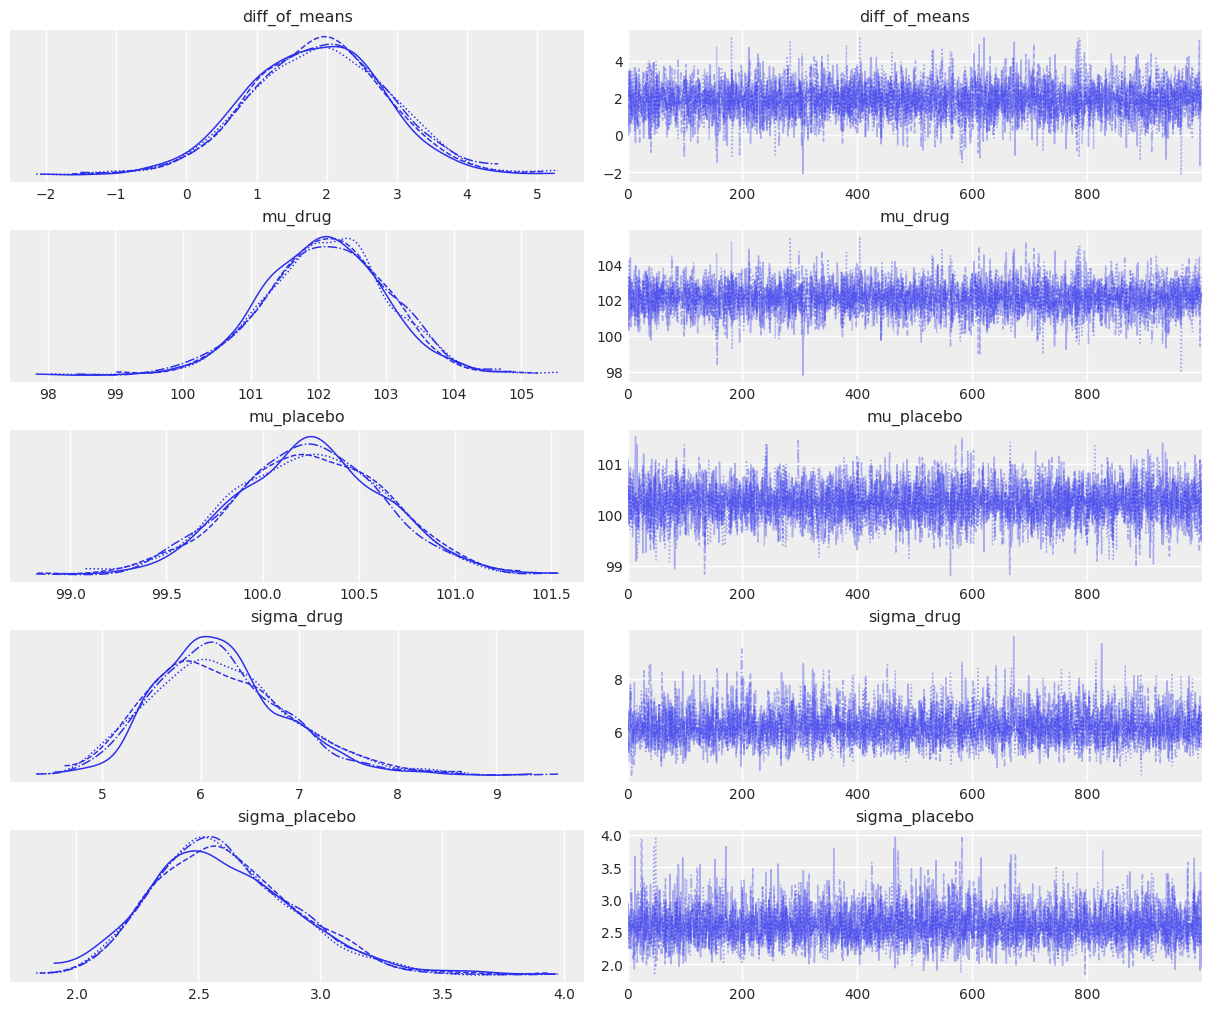

In [ ]:
#sampling was good. The posterior of sigma is very similar for both groups, while there are differences in  the posterior mean of the two groups.
az.plot_trace(normal_trace);

In [ ]:
# The posterior distribution can be checked in different ways, depending on the question we want to answer.

#Question 1: is the hypothesis of equal means of the two populations plausible?
#In traditional hypothesis testing, this corresponds to the two-tailed test about the mu1- mu2 = 0.
#The 0 values is very close to the lower bound of the 95% HDI and barely included. So formally 0 is still a plausible value.
az.summary(normal_trace, hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff_of_means,1.879,0.983,0.065,3.850,0.013,0.010,5369.0,3300.0,1.0
mu_drug,102.122,0.903,100.380,103.870,0.012,0.009,5419.0,3440.0,1.0
mu_placebo,100.243,0.387,99.497,101.007,0.005,0.004,5786.0,2870.0,1.0
sigma_drug,6.201,0.686,4.896,7.532,0.010,0.007,5149.0,2976.0,1.0
sigma_placebo,2.609,0.296,2.101,3.219,0.004,0.003,7467.0,3309.0,1.0


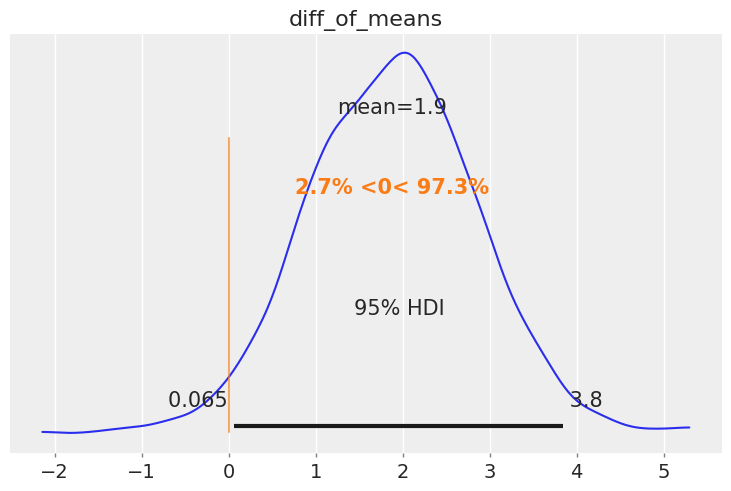

In [ ]:
# Question 2: which is the posterior probability of a  positive effect?
# This is the counterpart of the one-tailed test, whose alternative hypothesis is the drug being more effective than the placebo.
# There is a  probability >95% of the effect being positive; thus we accept the hypothesis of a positive effect.
az.plot_posterior(normal_trace,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95);

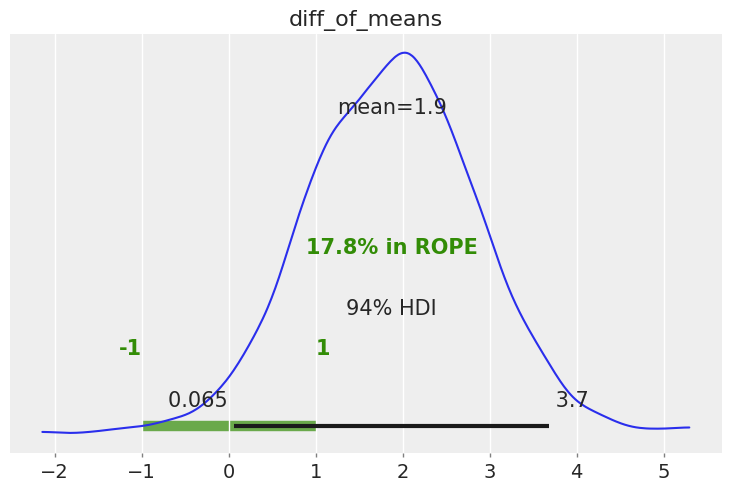

In [ ]:
# Question #3
# Assuming the differences of +-1 are practically negligible, we define the rope as [-1, +1].
# Which is the probability of the effect being practically negligible (i.e., the mean to be within to rope) or instead practically significant?
# The probability of rope isis around 18%. That is, there is 18% probability of the drug having an effect practically negligible.
# This type of analysis is not possible in frequentist tests.
az.plot_posterior(normal_trace,  var_names="diff_of_means", rope=[-1,1]);

In [ ]:
#Computing the probability of the positive effect being practically positive, practically negative or practically equivalent by working with the trace.
# This is a more detailed answer compared to the previous ones.
samples                  = az.extract(normal_trace)
diff_samples             = samples.diff_of_means.values
p_significant_positive   = (diff_samples > 1).sum() / len(diff_samples)
p_significant_negative   = (diff_samples < -1).sum() / len(diff_samples)
p_practically_eq         = 1 - p_significant_negative - p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

p_significant_positive:  0.819
p_practically_eq:  0.177
p_significant_negative:  0.004


# Posterior predictive checks

Output()

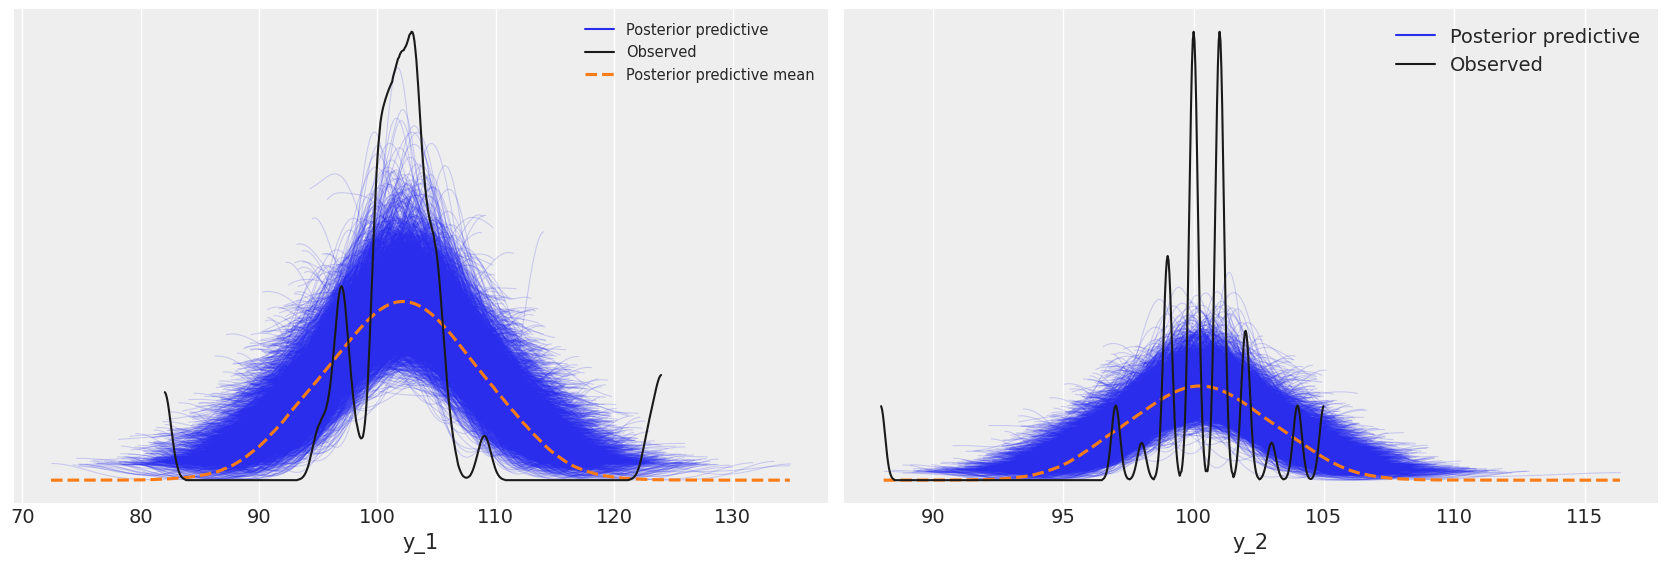

In [ ]:
# Quiz yourself: write a pseudo code explaining what the code below does.
with normal_model:
     ppc = pm.sample_posterior_predictive(normal_trace)

# The density is too low in the bulk of the distribution, for both groups.
az.plot_ppc(ppc);

## Robust likelihood

* The density is too low in the center of the distribution.



* We now adopt   as likelihood function a Student-t distribution with 4 degrees of freedom.

* If the degrees of freedom are more than 30, the Student distribution is practically equivalent to a Gaussian.

* A Student distribution with 4 degrees of freedom is recognized as able to deal with outliers.


$$y_{\text{drug},i} \sim StudentT(\mu_{\text{drug}}, \sigma_{\text{drug}}, \nu=4)$$

$$y_{\text{placebo},i} \sim StudentT(\mu_{\text{placebo}}, \sigma_{\text{placebo}},  \nu=4)$$


In [ ]:
with pm.Model() as student_model:
    #prior are  unchanged.
    mu_drug_t         = pm.Normal     ('mu_drug_t',     mu = 100,  sigma = 5)
    mu_placebo_t      = pm.Normal     ('mu_placebo_t',   mu = 100,  sigma = 5)
    sigma_drug_t      = pm.HalfNormal ('sigma_drug_t',  sigma=25)
    sigma_placebo_t   = pm.HalfNormal ('sigma_placebo_t', sigma=25)

    #But now we adopt a robust likelihood.
    #For simplicity we use a Student T with nu=4.  A more sophisticated approach would be to put a prior also on nu, but
    #that makes the model much more sensitive on the prior choice.
    y_drug    = pm.StudentT ('y_drug',nu=4, mu=mu_drug_t, sigma=sigma_drug_t, observed= iq_drug)
    y_placebo = pm.StudentT ('y_placebo', nu=4, mu=mu_placebo_t, sigma=sigma_placebo_t, observed= iq_placebo)

    #Derived quantities:
    diff_of_means_t = pm.Deterministic('diff_of_means', mu_drug_t - mu_placebo_t)
    student_trace   = pm.sample(return_inferencedata=True)

Output()

Output()

Output()

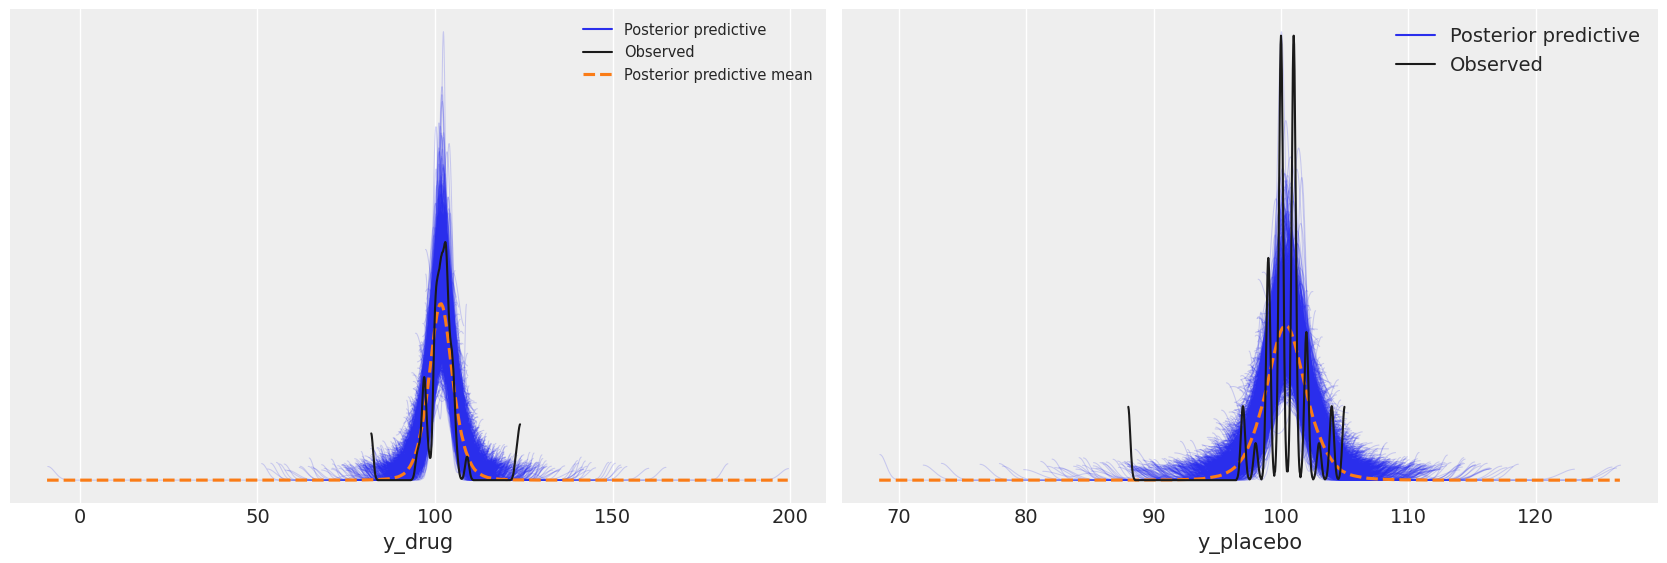

In [ ]:
#the fit is better compare to the normal model, though not yet perfect for the placebo group.
with student_model:
    ppc_t = pm.sample_posterior_predictive(student_trace)
    az.plot_ppc(ppc_t);

In [ ]:
# the standard deviation of the estimates (i.e., their uncertainty) decreases by almost a half compared to the Gaussian model,
# as a result of having filtered the outliers.
# the hdi become shorter, and interval on the difference between the two means becomes shorter and all in the positive region.
pd.concat( [az.summary(student_trace,  hdi_prob=0.95), az.summary(normal_trace, hdi_prob=0.95) ])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff_of_means,1.385,0.549,0.297,2.405,0.010,0.008,3196.0,1464.0,1.0
mu_drug_t,101.808,0.486,100.880,102.734,0.009,0.006,3177.0,1466.0,1.0
mu_placebo_t,100.423,0.256,99.877,100.900,0.005,0.003,2760.0,1552.0,1.0
sigma_drug_t,2.980,0.456,2.111,3.899,0.009,0.006,2835.0,1556.0,1.0
sigma_placebo_t,1.406,0.222,1.003,1.844,0.004,0.003,3503.0,1406.0,1.0
diff_of_means,1.879,0.983,0.065,3.850,0.013,0.010,5369.0,3300.0,1.0
mu_drug,102.122,0.903,100.380,103.870,0.012,0.009,5419.0,3440.0,1.0
mu_placebo,100.243,0.387,99.497,101.007,0.005,0.004,5786.0,2870.0,1.0
sigma_drug,6.201,0.686,4.896,7.532,0.010,0.007,5149.0,2976.0,1.0
sigma_placebo,2.609,0.296,2.101,3.219,0.004,0.003,7467.0,3309.0,1.0


# Re-answering questions with the robust model

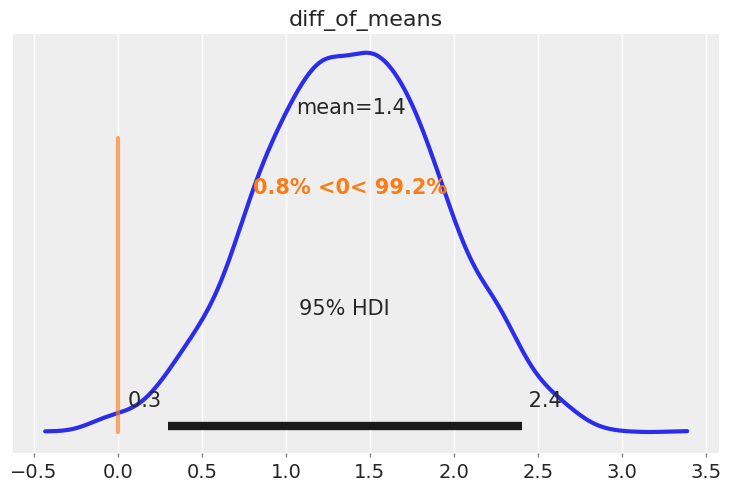

In [ ]:
# 0 is no longer within the HDI; it is no longer a plausible value.
# The robust model rejects the hypothesis of the two populations having the same mean.

az.plot_posterior(student_trace, var_names=['diff_of_means'],  ref_val=0, linewidth=3, hdi_prob=0.95);

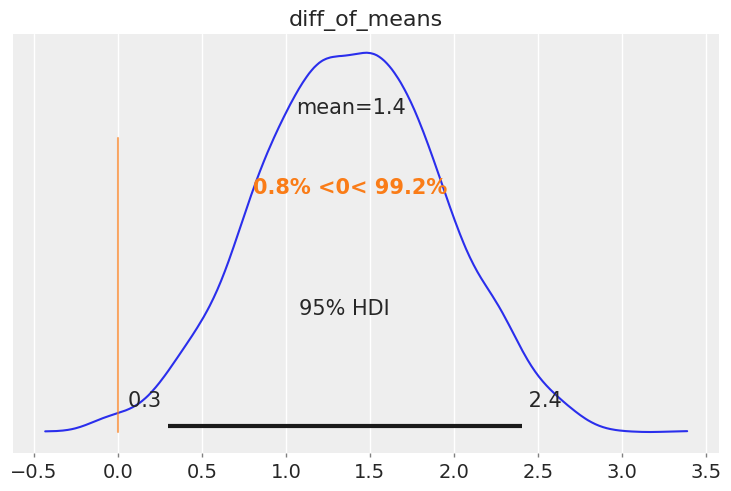

In [ ]:
# Posterior probability of a  positive effect increases wrt the Gaussian model.
az.plot_posterior(student_trace,  var_names="diff_of_means", ref_val=0, hdi_prob=0.95);

In [ ]:
#Posterior probability of the positive effect being practically positive, practically negative or practically equivalent,
#according to the robust model.

student_samples             = az.extract(student_trace)
diff_samples                = student_samples.diff_of_means.values
p_significant_positive      = (diff_samples > 1).sum() / len(diff_samples)
p_significant_negative      = (diff_samples < -1).sum() / len(diff_samples)
p_practically_eq            = 1-  p_significant_negative  -  p_significant_positive

print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

p_significant_positive:  0.756
p_practically_eq:  0.244
p_significant_negative:  0.000


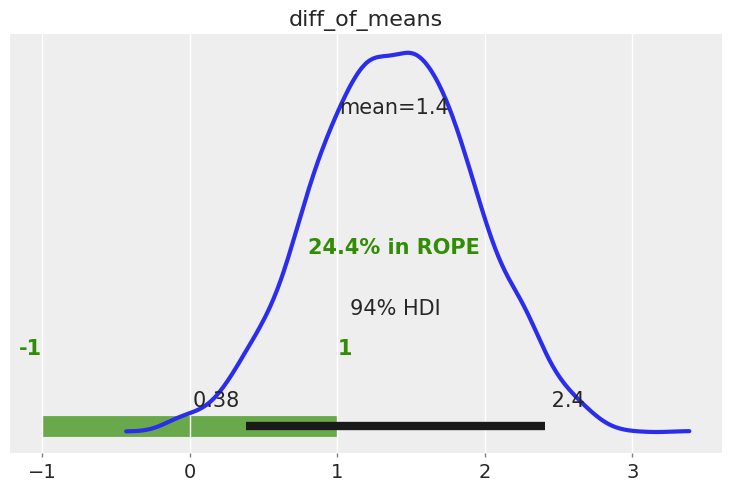

In [ ]:
az.plot_posterior(student_trace, var_names=['diff_of_means'], linewidth=3, rope=[-1,1]);

# Discussion

* The  analysis of the posterior density of $\mu_1 - \mu_2$ allows taking informative conclusions about the effectiveness of the drug.

* There is 98.7% probability of the drug having a *positive* effect ($P(\delta)>0$).

* If we introduce the rope, we have a more informative outcome: the drug has a positive (but practically irrelevant) effect with probability ~.25, and  a *practically positive* effect with probability 0.75. This is more informative, if you have to decide whether to further develop the drug o not (the choice will depend on the expected gains and losses in both cases).

* In general the conclusions based on the rope are more informative than the simple probability of the effect being positive.

* You can repeat the analysis with different ropes, as the choice of the rope is subjective.


# Re-analysis of the data set of beauty and sex ratio

* A social scientist observed the following in a study involving some thousands of American couples:

* The proportion of girls among the children of “highly attractive” parents is 56% (𝑋 = 168, 𝑛 = 300).

* The proportion of girls among the children of “standard attractive” parents is 48% (𝑋 = 1296, 𝑛 = 2700).

# Hypothesis test

\begin{align*}
H_0 &: \pi_{\text{attr}} ≤ \pi_{\text{std}}\\
H_1 &: \pi_{\text{attr}} > \pi_{\text{std}}
\end{align*}



# Frequentist analysis


\begin{align*}
Z &= \frac{p_{attr} - p_{std}} { \sqrt{\bar{p} (1 - \bar{p})  
(\frac{1}{n_1} + \frac{1}{n_2}} )} = 2.63
\end{align*}

* The critical value ($\alpha=0.01$) is $2.33$.

* The null hypothesis is rejected; the proportion of girls in the two groups is significantly different.

# Prior knowledge for Bayesian analysis

* The variation in the human sex ratio occurs in a very narrow range.

* For example, a recent count in the United States reported 48.7% girls among whites  and 49.2% among blacks.

* Similar differences (half of a percentage point or less) have been found when comparing based on factors such as birth order, maternal age, or season of birth.

*  In the world, the sex ratio varies between 46% and 50% depening on the country.


# Tune the beta prior for girl ratio

* Consider the prior Beta($\alpha,\beta$)

* We set its expected value to 0.48, which implies $\beta = \frac{52}{48}\alpha$

* We let plausible values range between 0.45 and 0.50.

* After some trial and error, we settle for:
\begin{align*}
\alpha &=800 \\
\beta &= \frac{52}{48}800 = 866
\end{align*}

In [ ]:
from scipy.stats import beta

# here are some attempts
c = 52/48 #multiplicative constant

a = 10
beta.interval(confidence = 0.95, a = a, b = c*a)
# 0.27 - 0.68: too large

a = 100
beta.interval(confidence = 0.95, a = a, b = c*a)
# 0.41 - 0.55: still too large

a = 200
beta.interval(confidence = 0.95, a = a, b = c*a)
# 0.43 - 0.53: still too large.
# The intervals changes very little as we increase a.

a = 800
beta.interval(confidence = 0.95, a = a, b = c*a)
# 0.456 0.504: that seems rights.

(0.45604761650156495, 0.5039978484149319)

# Tune the Beta prior

* The choice $\alpha=800,\beta = 866$ shows that we have strong prior knowledge.

* In the conjugate interpretation of the beta-binomial priors,  this prior is equivalent to having 1666 additional hidden samples (of which 800 successes).


# Beta-binomial model of the two groups and the the difference between the two $\theta$_s

\begin{align*}
\theta_{\text{attr}} &\sim \text{Beta}(800, 866)\\
X_{\text{attr}} &\sim \text{Binom}(y =1296, n=2700, p=\theta_{\text{attr}})\\
\\
\theta_{\text{std}} &\sim \text{Beta}(800, 866)\\
X_{\text{std}} &\sim \text{Binom}(y=168, n=300, p=\theta_{\text{std}})\\
\\
\delta \theta &= \theta_{\text{attr}} - \theta_{\text{std}}
\end{align*}



# Posterior of the two groups

Since the model is conjugate, the posteriors are:



\begin{align*}
\alpha_{\text{std}} &= 800 + 1296 = 2096 \\
\beta_{\text{std}} &= 866 + 2700 - 1296 = 2270\\
\theta_{\text{std}} &\sim \text{Beta}(2096, 2270)\\
\\
\alpha_{\text{attr}} &= 800 + 168 = 968 \\
\beta_{\text{attr}} &= 866 + 132 = 932\\
\theta_{\text{attr}} &\sim \text{Beta}(968, 932)
\end{align*}


* We do not need probabilistic programming as we already analitically have the posterior of the two groups. In general we need instead to use prob programming (as in the previous example about drug effect).

* In the second group the prior knowledge is stronger than the knowledge extracted from the data.


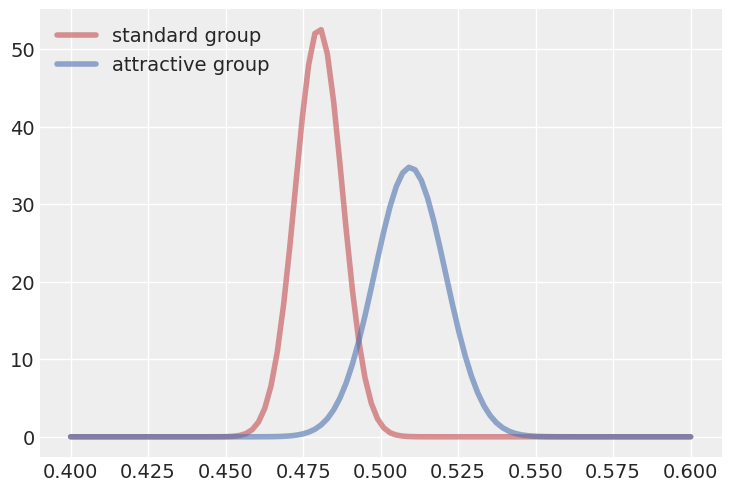

In [ ]:
#get the posterior 95% interval

beta.interval(confidence = 0.95, a = 2096, b = 2270)
# 0.465 0.494, more or less what we expect in the general population


beta.interval(confidence = 0.95, a = 968, b = 932)
# 0.487 0.53. Does not comprise the sample proportion of 0.58

#We plot the two posteriors
# I constrain the limits of the plot between .4 and .6
x = np.linspace(0.4, 0.6, 100)
plt.plot(x, beta.pdf(x, a=2096, b=2270), 'r-', lw=4, alpha=0.6, label='standard group')
plt.plot(x, beta.pdf(x, a=968, b=932), 'b-', lw=4, alpha=0.6, label='attractive group')

plt.legend(loc="upper left")

# Is the posterior difference between the two groups significant?

* We shall check if the posterior HDI of the difference contains 0.

* We have the posterior betas of the two groups, which are indepedenent.

* We  obtain the distribution of the posterior difference by sampling from the first group, the second group and then creating a sample of differences.




In [ ]:
# Is the difference between the proportion in the two groups significantly different from 0?
#samples from the first group, the second group and samples of the difference
post_standard = beta.rvs(a=2096, b=2270, size=10000)
post_attractive = beta.rvs(a=968, b=932, size=10000)
post_diff =  post_attractive - post_standard

# prob of a positive difference
print("prob positive difference: ", np.mean(post_diff>0))

# The lower bound of the 95% CI of the differences  is very close to 0
q=np.quantile(post_diff, q=[.025, .975])
print("95% posterior interval of the difference: ", q)

prob positive difference:  0.9846
95% posterior interval of the difference:  [0.0026102  0.05619229]


# Discussion

* The 95% posterior HDI is (0.001, 0.056) formally does not contain 0, although its lower bound is very close to it. Ruling out the null hypothesis is not a robust conclusion.


* The sample difference ($p_1 - p_2 = 0.08$) is outside the HDI; the HDI is pulled towards smaller differences by prior knowledge.

# Analysis with rope

* Let us assume the rope to be (-0.01, 0.01).

* Let us computed the posterior probability of $\delta\theta$ belonging to the rope, and lying at its left and its right.

* The probability of $\delta \theta$ being within the rope is about 0.08, clearly we cannot reject this null.

* This seems a more sensible conclusion.

p_practically_eq:  0.078
p_significant_positive:  0.922
p_significant_negative:  0.002


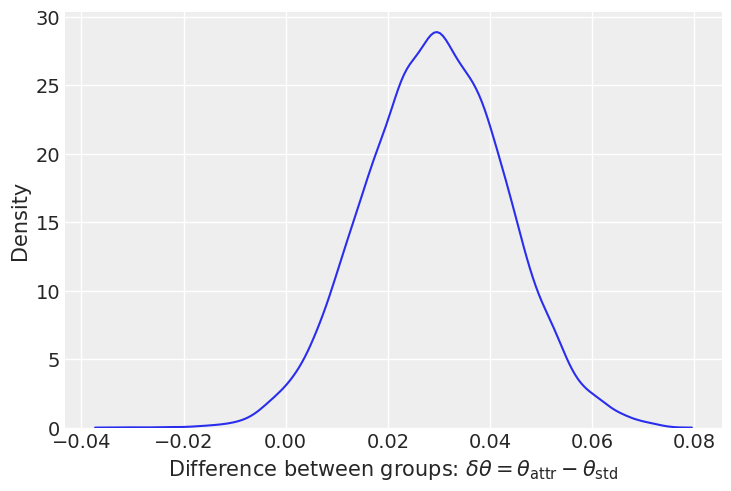

In [ ]:
# Analysis with ROPE
# Even better than the null hypothesis of a sharp difference of 0, let us introduce a rope of +- 0.01
# We assume that the difference in gender ratio has to be larger than 0.01 to be practically significant
ax = sns.kdeplot(post_diff)
ax.set_xlabel(r'Difference between groups: $\delta \theta = \theta_{\text{attr}} - \theta_{\text{std}}$')
p_practically_eq       = np.mean(np.abs(post_diff < 0.01))
p_significant_negative = np.mean(post_diff < -0.01)
p_significant_positive = np.mean(post_diff > 0.01)

print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_positive: ", "%.3f" % p_significant_positive)
print("p_significant_negative: ", "%.3f" % p_significant_negative)

# Re-analysis with flat prior (no prior information)

* If we use a Beta(1,1) prior:

\begin{align*}
\alpha_{\text{std}} &= 1 + 1296 = 1297 \\
\beta_{\text{std}} &= 1 + 1404 = 1495\\
\theta_{\text{std}} &\sim \text{Beta}(1297, 1405)\\
\\
\alpha_{\text{attr}} &= 1 + 168 = 169 \\
\beta_{\text{attr}} &= 133 + 132 = 133 \\
\theta_{\text{attr}} &\sim \text{Beta}(968, 932)
\end{align*}


In [ ]:
#samples from the first group, the second group and samples of the difference
post_standard_beta11 = beta.rvs(a=1297, b=1495, size=10000)
post_attractive_beta11 = beta.rvs(a=169, b=133, size=10000)
post_diff_beta11 = post_attractive_beta11 -  post_standard_beta11

#ax = sns.kdeplot(post_diff_beta11)
#ax.set_xlabel(r'Difference between groups with Beta (1,1) prior: $\delta \theta = \theta_{\text{attr}} - \theta_{\text{std}}$')
p_practically_eq       = np.mean(np.abs(post_diff_beta11 < 0.01))
p_significant_negative = np.mean(post_diff_beta11 < -0.01)
p_significant_positive = np.mean(post_diff_beta11 > 0.01)

# a lot of uncertainty in the posterior interval if we have no prior knowledge
q=np.quantile(post_diff_beta11, q=[.025, .975])
print("Analysis without rope:")
print("95% posterior interval of the difference: ", q)

Analysis without rope:
95% posterior interval of the difference:  [0.03605642 0.15172263]


# Conclusions

* If we had no prior knowledge, the outcome of the test would be consistent with the frequentist test (declaring significance of the differences).

* However a flat prior on gender ratio is not tenable, as we have substantive knowledge.

* Generally defining a rope and report the posterior probability of $\delta \theta$ belonging to the rope, falling into its left and its right is more valuable than simply checking the probability of the difference being positive.

> Kruschke, John K. "Bayesian estimation supersedes the t test." Journal of Experimental Psychology: General 142.2 (2013): 573.

# Posterior distribution of functions of the parameters:  effect size

An indicator used to  compare the means of the two populations is *effect size* (Cohen's $d$):

$$
\displaystyle
\frac{\mu_2 - \mu_1}{\sigma_P}$$

where  $\sigma_P$ is the pooled standard deviation,  $\sigma_P = \sqrt{ \frac{\sigma_2^2 + \sigma_1^2}{2} }$

* Effect size is  the amount of change induced by the treatment relative to the standard deviation. It is often used in medical studies.



* Once we have the posterior samples of $\mu_1, \mu_2, \sigma$ we can computer the posterior distribution of other indicators, which are deterministic functions of them.

# Exercise 1

* In the drug example, compute the posterior probability of the effect size being:

    * negative ($d < 0$)

    * positive small ($0 \leq d \leq 0.3$)

    * positive, medium strenght  ($0.3 \leq d \leq 0.8$)

    * positive, large ($d >  0.8$)



* Hints:

    * define `effect_size` as a deterministic variable of the model.

    * use `extract_dataset` to access the samples of the trace.

# Exercise 2: comparing death rates between different treatments

* An experiment was performed to estimate the effect of beta-blockers on mortality of cardiac patients, which in general is comprised between 1% (0.01) and 9% (0.09).


* Out of 674 patients of the control group (placebo) 39 died;  out of 680 receiving the treatment, 22 died.


* Assume that the outcomes are independent and binomially distributed, with  probabilities of death   $\theta_{\text{control}}$ and $\theta_{\text{treatment}}$.

* A difference in death rates within the interval $\pm$0.005 is considered small enough to have no practical consequence.

* Draw your conclusions by analyzing the posterior distribution of the difference between the  death rates in the two groups.

# Hints

* Tune the parameters of the  beta prior by checking the limits of the 95% HDI interval; see the interval method of [the beta distribution in scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html)


* The syntax for the binomial likelihood in pymc is `pm.Binomial('variable_name', n=number of trials, p = theta, observed= number of successes)`

# Solutions

In [ ]:
#computing the effect size as a deterministic variable within the student model.

with pm.Model() as student_model_effect:
    #prior are  unchanged.
    mu_drug_t           = pm.Normal     ('mu_drug_t',       mu = 100,  sigma = 5)
    mu_placebo_t        = pm.Normal     ('mu_placebo_t',    mu = 100,  sigma = 5)
    sigma_drug_t        = pm.HalfNormal ('sigma_drug_t',    sigma=25)
    sigma_placebo_t     = pm.HalfNormal ('sigma_placebo_t', sigma=25)

    y_drug = pm.StudentT ('y_drug',       nu=4, mu=mu_drug_t,  sigma=sigma_drug_t,       observed= iq_drug)
    y_placebo = pm.StudentT ('y_placebo', nu=4, mu=mu_placebo_t, sigma=sigma_placebo_t, observed= iq_placebo)

    #Effect size as a deterministic variable.
    effect_size  = pm.Deterministic('effect_size', (mu_drug_t - mu_placebo_t) / (  (sigma_drug_t**2 + sigma_placebo_t**2) /2 )**(1/2))
    student_trace_effect    = pm.sample(return_inferencedata=True)

Output()

Output()

In [ ]:
#Posterior probability of the effect size being negative, or positive  (disaggregated as small, medium and large).
samples                  = az.extract_dataset(student_trace_effect)
effect_samples      = samples.effect_size.values

# count the samples in which the effect size negative
p_negative             = ( ( (effect_samples<0).sum() ) /  len (effect_samples) )

#a slightly more complex syntax is necessary to count the sample within a given range
p_small                   =  np.logical_and(effect_samples > 0,  effect_samples < 0.3)
p_small                   =  p_small.sum() / len (effect_samples)

p_medium             =  np.logical_and(effect_samples > 0.3,  effect_samples < 0.8)
p_medium             =  p_medium.sum() / len (effect_samples)

p_large                   = ( ( (effect_samples>0.8).sum() ) /  len (effect_samples) )

print("p effect size is negative: ", "%.3f" % p_negative)
print("p effect size is small: ", "%.3f" % p_small)
print("p effect size is medium: ", "%.3f" % p_medium)
print("p effect size is large: ", "%.3f" % p_large)

#check the computed probs sum up to 1
print ("sum: ", p_large + p_medium + p_small + p_negative)

p effect size is negative:  0.009
p effect size is small:  0.114
p effect size is medium:  0.667
p effect size is large:  0.210
sum:  1.0


<ipython-input-28-62d11d53e1a2>:2: FutureWarning: extract_dataset has been deprecated, please use extract
  samples                  = az.extract_dataset(student_trace_effect)


# Comparing the death rates between two beta blockers

# First, we need tuning the Beta prior

* We know that the mortality rate is between 1% and 9%; the median point of the interval is 0.05.

* We thus set the expected value of the beta such that $\alpha$/($\alpha + \beta$) = 0.05.
  
* Hence, $\alpha$ = $\beta$ * 0.05 / 0.95.

* For instance for $\beta$=100, we get $\alpha = 100 * 0.05 / 0.95 = 5.2$ (which I round to 5 for simplicity)


In [ ]:
import scipy.stats as stats
b =  100
a =  5
random_var = stats.beta(a,b)
interval95 = random_var.interval(confidence=0.95)

#this interval is already satisfactory, as it well represents our prior information.
#no further tuning required
print(np.round(interval95,3)) #[0.016 0.096]

[0.016 0.096]


In [ ]:
# Analysis of the mortality using the beta-binomial model
# We could equivalently compute the posterior betas and the difference between their samples.
# A Beta(5,100) has expected value 0.05, and most of its mass below 0.1. This represents  appropriately our prior information.

with pm.Model() as binomial_diff:
    theta_treatment = pm.Beta('theta_treatment', alpha=5, beta=100)
    theta_control   = pm.Beta('theta_control', alpha=5, beta=100)

    #we need to write the model using the binomial likelihood
    dead_treatment = pm.Binomial ('dead_treatment ',  p=theta_treatment, observed=22, n=680)
    dead_control   = pm.Binomial ('dead_control ',    p=theta_control, observed=39, n=674)

    #Difference between the two mortality rates is a deterministic variable.
    diff_theta      = pm.Deterministic('diff_theta', theta_treatment - theta_control)
    binomial_trace  = pm.sample(return_inferencedata=True)

Output()

Output()

In [ ]:
#The binomial trace also contains samples for diff_theta
az.summary(binomial_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diff_theta,-0.022,0.010,-0.041,-0.002,0.0,0.0,2191.0,1422.0,1.0
theta_control,0.057,0.008,0.041,0.072,0.0,0.0,2232.0,1381.0,1.0
theta_treatment,0.034,0.007,0.023,0.047,0.0,0.0,2087.0,1302.0,1.0


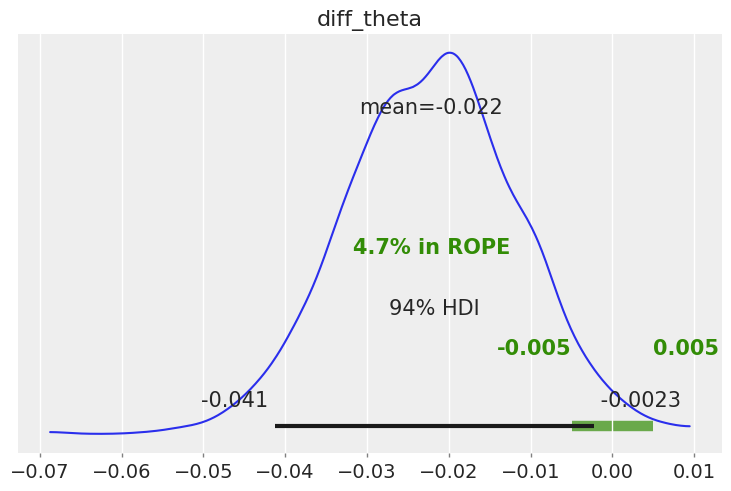

In [ ]:
# there is about only 4% probability of the treatment being practically equivalent
# to the placebo.

# We also accept the hypothesis of the treatment reducing the mortality rate, as there is probability > 95%
# of the  treatment reducing the mortality rate.
# A more detailed analysis could consider different intervals, and report the posterior probability of the treament being slightly / medium/ very effective.
az.plot_posterior(binomial_trace, var_names='diff_theta', rope= [-0.005, 0.005]);


In [ ]:
#Posterior probability of the  effect of the drug on the death rate:
#decreases by an amount outside the rope (statistically significant reduction)
#is within the rope (drug and placebo are practically equivalent)
#increases by an amount outside the rope (statistically significant increase)

#There is strong evidence in favor of the treatment.
binomial_samples            = az.extract(binomial_trace)
diff_samples                = binomial_samples.diff_theta.values
p_significant_increase      = (diff_samples > 0.005).sum()  / len(diff_samples)
p_significant_decrease      = (diff_samples < -0.005).sum() / len(diff_samples)
p_practically_eq            = 1-  p_significant_increase  -  p_significant_decrease

print("p (drug significantly increase the death rate): ", "%.3f" % p_significant_increase)
print("p_practically_eq: ", "%.3f" % p_practically_eq)
print("p_significant_decrease: ", "%.3f" % p_significant_decrease)

p (drug significantly increase the death rate):  0.004
p_practically_eq:  0.047
p_significant_decrease:  0.950
